In [2]:
import numpy as np
import torch

from astropy import table as astropy_table

import torch_geometric.transforms as ttr

from mptd.reader import get_raw_data
from mptd.simple_message import SimpleMessage
from mptd.data_types import SimTransientData
from mptd.plotter import plot_data, plot_clusters, plot_fits_data
from mptd.clusterer import get_clusters

from scipy.spatial.distance import euclidean
from mptd.smallest_enclosing_circle import welzl

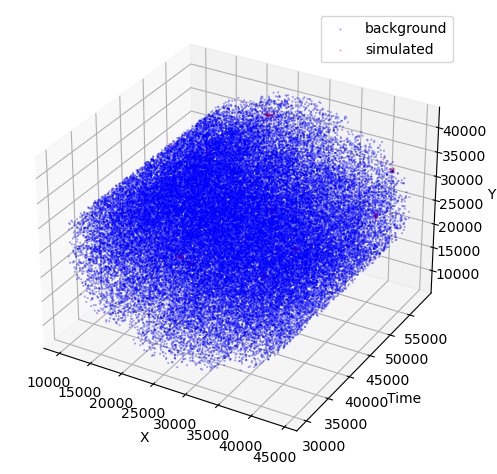

In [3]:
import os.path as osp
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ")
keys = ["PI", "X", "TIME", "Y"]
raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                        y = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).long())

plot_data(data.x, (0.1, 0.1), data.y.bool(), keys)


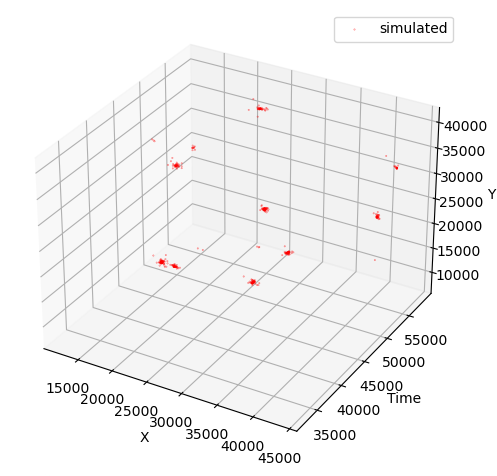

In [4]:

plot_data(data.x, (0.0, 0.1), data.y.bool(), keys)

In [5]:
import os.path as osp
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

import torch

def my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=1, plot_after = 0, spectrum=True, max_threshold=0.5):
    elaborated_data = torch.ones_like(net_data.x[:, 0].unsqueeze(-1))
    # issimulated=net_data.y.bool()

    for i in range(layers):
        elaborated_data += model.forward(elaborated_data, net_data.edge_index)#, edge_weight=gaussian_kernel(distances, distances.median()*1000))
        sizes = elaborated_data[:,0]
        # threshold = torch.quantile(sizes,  quantile).item()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        if (i+1)%plot_every == 0 and i >= plot_after:
            plot_data(net_data.x[mask].cpu(), sizes[mask].cpu(), issimulated=net_data.y[mask].cpu().bool(), keys=keys, title=f"iteration {i+1}", outfile=osp.join("video_frames", f"frame_{i:02}.png"))
        elaborated_data /= elaborated_data.max()


    masked_data = SimTransientData(x=net_data.x[mask], y= net_data.y[mask]).cpu()
    masked_sizes = sizes[mask].cpu()

    if spectrum:
        cluster = SpectralClustering(affinity="nearest_neighbors", n_neighbors=8, assign_labels="cluster_qr", n_jobs=-1)
        labels = cluster.fit_predict(masked_data.x[:, 1:])
    else:
        dbscan = DBSCAN(eps=distances.median().item()/2, min_samples=5)  # Adjust parameters according to your data
        labels = dbscan.fit_predict(masked_data.x[:, 1:])

    return masked_data, masked_sizes, labels, mask.cpu(), elaborated_data.cpu()

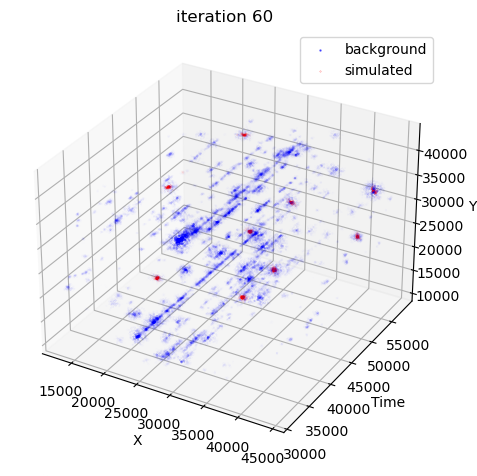

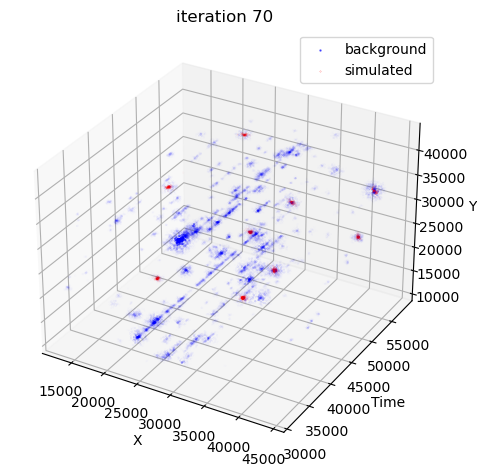

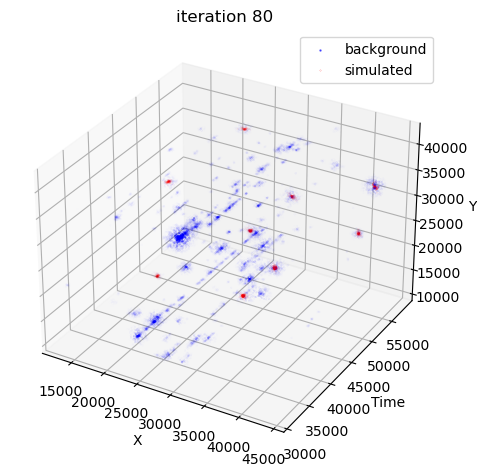

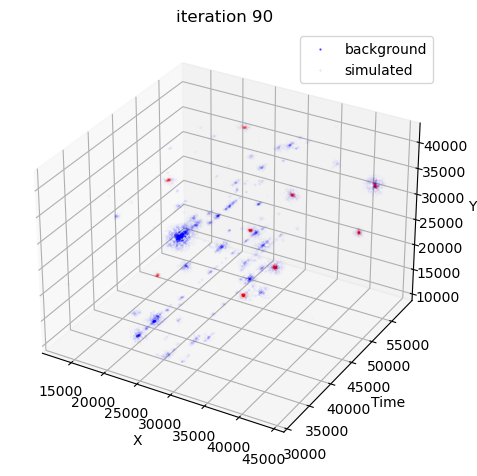

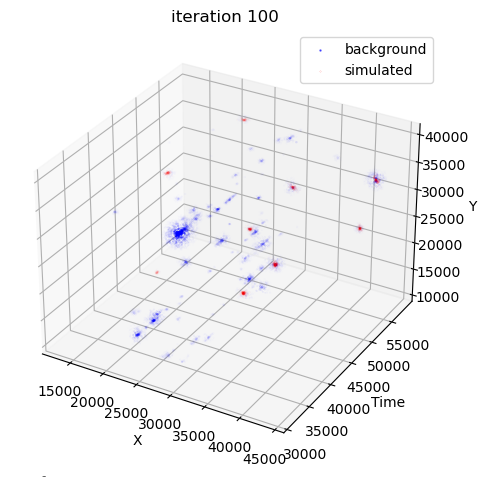

In [7]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601PNS003PIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 100
quantile = 0.6

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                        y = issimulated.long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask, elaborated_data = \
    my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=10, plot_after=50, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

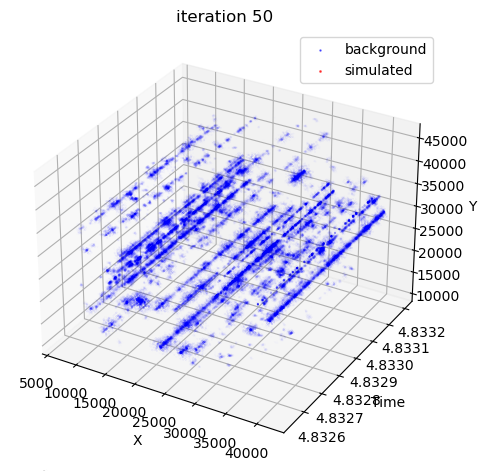

In [6]:
import os.path as osp

filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
# filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.99

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                        y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask, elaborated_data = \
    my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=layers, plot_after=5, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

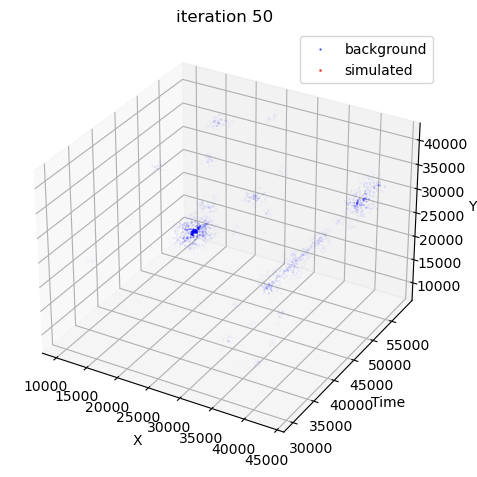

In [7]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.99

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                        y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask, elaborated_data = \
    my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=layers, plot_after=5, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

In [8]:
mask.sum()

tensor(2105)

In [ ]:
data_cumulated         = data
issimulated_cumulated  = issimulated
masked_data_cumulated  = masked_data
masked_sizes_cumulated = masked_sizes
labels_cumulated       = labels
mask_cumulated         = mask

In [ ]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M1S001MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.99

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                        y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask, elaborated_data = \
    my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=layers, plot_after=5, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

In [ ]:
data_cumulated = data_cumulated.append(data)
issimulated_cumulated = torch.hstack([issimulated_cumulated, issimulated])
masked_data_cumulated = masked_data_cumulated.append(masked_data)
masked_sizes_cumulated=torch.hstack([masked_sizes_cumulated, masked_sizes])
labels_cumulated=np.append(labels_cumulated, labels)
mask_cumulated=torch.hstack([mask_cumulated, mask])

In [ ]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601PNS003PIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.99

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                        y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask, elaborated_data = \
    my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=layers, plot_after=5, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

In [ ]:
data_cumulated = data_cumulated.append(data)
issimulated_cumulated = torch.hstack([issimulated_cumulated, issimulated])
masked_data_cumulated = masked_data_cumulated.append(masked_data)
masked_sizes_cumulated=torch.hstack([masked_sizes_cumulated, masked_sizes])
labels_cumulated=np.append(labels_cumulated, labels)
mask_cumulated=torch.hstack([mask_cumulated, mask])

In [ ]:
# result_list = np.array(result_list)
masked_data_cumulated, masked_sizes_cumulated, labels_cumulated, mask_cumulated

In [ ]:

data_cumulated = data_cumulated.cpu()
masked_issimulated_cumulated = masked_data_cumulated.y.bool().cpu()

plot_data(data_cumulated.x, (0.01, 0.5), issimulated_cumulated, keys)
plot_data(masked_data_cumulated.x, masked_sizes_cumulated, masked_issimulated_cumulated, keys)
plot_clusters(masked_data_cumulated.x[:, 1:4], masked_sizes_cumulated, labels_cumulated, keys[1:4])
dbscan = DBSCAN(eps=distances.median().item()/2, min_samples=5)  # Adjust parameters according to your data
all_labels = dbscan.fit_predict(masked_data_cumulated.x[:, 1:4])
plot_clusters(masked_data_cumulated.x[:, 1:4], masked_sizes_cumulated, all_labels, keys[1:4])
plot_data(data_cumulated.x, (0.0, 0.5), issimulated_cumulated, keys)

In [ ]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filenames = []
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M1S001MIEVLF0000.FTZ")) # easy example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ")) # easy example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601PNS003PIEVLF0000.FTZ")) # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 100
quantile = 0.999

raw_data = get_raw_data(filename=filenames[0], keys=keys, filters={"FLAG": (0,4)})
for filename in filenames[1:]:
    print(filename, len(raw_data))
    raw_data = astropy_table.vstack([raw_data, get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})])

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                        y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask, elaborated_data = \
    my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=10, plot_after=10, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def old_plot_mean_with_errorbars(tensor, labels):
    unique_labels = np.unique(labels)
    fig, ax = plt.subplots()

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        group_coords = tensor[indices]

        mean_coords = torch.mean(group_coords, dim=0)
        std_coords = torch.std(group_coords, dim=0)

        size = np.log10(len(indices))*10
        color = group_coords[:, 1].std()  # Standard deviation along the second dimension

        ax.errorbar(mean_coords[0], mean_coords[-1], xerr=std_coords[0], yerr=std_coords[-1],
                    fmt='o', markersize=size, color=plt.cm.RdYlBu(color), alpha=0.5)
        
def oldish_plot_mean_with_errorbars(tensor, labels):
    unique_labels = np.unique(labels)
    fig, ax = plt.subplots()

    cbar_data = []  # Collect colorbar data

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        group_coords = tensor[indices]

        mean_coords = torch.mean(group_coords, dim=0)
        std_coords = torch.std(group_coords, dim=0)

        size = np.log10(len(indices))*5
        color = torch.std(group_coords[:, 1], dim=0)  # Standard deviation along the second dimension

        cbar_data.append(color)  # Collect colorbar data

        ax.errorbar(mean_coords[0], mean_coords[-1], xerr=std_coords[0], yerr=std_coords[-1],
                    fmt='o', markersize=size, color=plt.cm.RdYlBu(color), alpha=0.7)

    ax.set_xlabel('First Dimension')
    ax.set_ylabel('Last Dimension')
    ax.set_title('Mean with Error Bars')

    # Create a colorbar
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=plt.cm.RdYlBu), cax=cax)
    cbar.set_label('Standard Deviation along Second Dimension')

    plt.show()
        
def plot_mean_with_errorbars(tensor, labels, time_threshold=np.inf):
    unique_labels = np.unique(labels)
    fig, ax = plt.subplots()
    colsm = plt.cm.ScalarMappable(norm=None, cmap=plt.cm.RdYlBu)
    colsm

    cbar_data = []  # Collect colorbar data
    xs = []
    xerrs = []
    ys = []
    yerrs = []
    sizes = []
    colors = []

    for label in unique_labels:
        if label == -1: continue
        indices = np.where(labels == label)[0]
        group_coords = tensor[indices]

        mean_coords = torch.mean(group_coords, dim=0)
        std_coords = torch.std(group_coords, dim=0)

        size = np.log10(len(indices))*5
        color = torch.std(group_coords[:, 1], dim=0)  # Standard deviation along the second dimension

        if color > time_threshold: continue

        cbar_data.append(color)  # Collect colorbar data
        
        # ax.errorbar(mean_coords[0], mean_coords[-1], xerr=std_coords[0], yerr=std_coords[-1],
        #             fmt='o', markersize=size, color=plt.cm.RdYlBu(color.item()), alpha=0.7)
        # print(plt.cm.RdYlBu(color.item()))

        xs.append(mean_coords[0].item())
        xerrs.append(std_coords[0].item())
        ys.append(mean_coords[-1].item())
        yerrs.append(std_coords[-1].item())
        sizes.append(size)
        colors.append(color)

    assert len(colors) == len(xs)

    colors = np.array(colors).squeeze()
    # colors /= colors.max()

    colsm.set_array(colors)

    for x, y, xerr, yerr, color, size in zip(xs, ys, xerrs, yerrs, colors, sizes):
        ax.errorbar(x, y, xerr=xerr, yerr=yerr, c=colsm.to_rgba(color, alpha=0.7), alpha=0.7, fmt='o')
    # ax.scatter(xs, ys, s=sizes, c=colors, cmap='viridis', alpha=0.7)

    ax.set_xlabel('First Dimension')
    ax.set_ylabel('Last Dimension')
    ax.set_title('Mean with Error Bars')

    # Create a colorbar
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(colsm, cax=cax)
    cbar.set_label('Standard Deviation along Second Dimension')

    plt.show()

In [ ]:

data = data.cpu()

# plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data.x, masked_sizes, masked_issimulated, keys)
plot_clusters(masked_data.x[:, 1:4], masked_sizes, labels, keys[1:4], figsize=(6,6))
plot_data(data.x, (0.0, 0.5), issimulated, keys)
plot_mean_with_errorbars(masked_data.x[:, 1:4], labels, 1000)

In [ ]:
label = 2
tensor = data.x[:, 1:4]
overlabels = np.full_like(mask, fill_value=-1)
overlabels[mask] = labels
epsilon = 0.
indices = np.where(labels == label)[0]
old_group_coords = tensor[indices]
coords_2d = old_group_coords[:, [0,2]]
sec = welzl(coords_2d)
print(((tensor[:, [0,2]].numpy() - np.array(sec.center))**2).sum() <= sec.radius + epsilon)
group_coords = tensor[((tensor[:, [0,2]] - torch.tensor(sec.center))**2).sum(axis=1) <= sec.radius + epsilon]
print(len(old_group_coords))
print(group_coords)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*group_coords.T, c="blue")
ax.scatter(*old_group_coords.T, c="red")

In [ ]:

def plot_light_curves(tensor, labels, time_threshold=np.inf, bins=50, epsilon=0):
    unique_labels = np.unique(labels)

    for label in unique_labels:
        if label == -1: continue
        indices = np.where(labels == label)[0]
        group_coords = tensor[indices]
        coords_2d = group_coords[:, [0,2]]
        center, radius = smallest_enclosing_circle(coords_2d)
        group_coords = tensor[euclidean(tensor[:, [0,2]], center) <= radius + epsilon]
        time_dev = torch.std(group_coords[:, 1], dim=0)  # Standard deviation along the second dimension
        if time_dev > time_threshold: continue

        plt.hist(group_coords[:, 1].numpy(), bins=bins)
        plt.xlabel("Time")
        plt.title(f"Cluster #{label}")

        plt.show()

In [ ]:
overlabels = np.full_like(mask, fill_value=-1)
overlabels[mask] = labels
plot_light_curves(data.x[:, 1:4], overlabels, bins=100)

In [ ]:
assert False

In [ ]:
import os.path as osp
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

import torch

def my_get_clusters_with_pruning(net_data, distances, model, layers, quantile, transform, plot_every=1, plot_after = 0, spectrum=True, max_threshold=0.5):
    elaborated_data = torch.ones_like(net_data.x[:, 0].unsqueeze(-1))
    # issimulated=net_data.y.bool()

    for i in range(layers):
        elaborated_data += model.forward(elaborated_data, net_data.edge_index)#, edge_weight=gaussian_kernel(distances, distances.median()*1000))
        sizes = elaborated_data[:,0]
        # threshold = torch.quantile(sizes,  quantile).item()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        net_data = transform(SimTransientData(x=net_data.x[mask], y= net_data.y[mask]))
        if (i+1)%plot_every == 0 and i >= plot_after:
            plot_data(net_data.x.cpu(), sizes[mask].cpu(), issimulated=net_data.y.cpu().bool(), keys=keys, title=f"iteration {i+1}", outfile=osp.join("video_frames", f"frame_{i:02}.png"))
        elaborated_data /= elaborated_data.max()
        elaborated_data = elaborated_data[mask]


    masked_data = net_data.cpu()
    masked_sizes = sizes[mask].cpu()

    if spectrum:
        cluster = SpectralClustering(affinity="nearest_neighbors", n_neighbors=8, assign_labels="cluster_qr", n_jobs=-1)
        labels = cluster.fit_predict(masked_data.x[:, 1:])
    else:
        dbscan = DBSCAN(eps=distances.median().item()/2, min_samples=5)  # Adjust parameters according to your data
        labels = dbscan.fit_predict(masked_data.x[:, 1:])

    return masked_data, masked_sizes, labels, mask.cpu()

In [ ]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 30
quantile = 0.6

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                        y = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask = \
    my_get_clusters_with_pruning(net_data, distances, model, layers, quantile, transform, plot_every=5, plot_after=5, spectrum=False)

masked_issimulated=masked_data.y.bool()

In [ ]:

data = data.cpu()
issimulated = issimulated.cpu()

plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data.x, masked_sizes, masked_issimulated, keys)
plot_clusters(masked_data.x[:, 1:4], masked_sizes, labels, keys[1:4])
plot_data(data.x, (0.0, 0.5), issimulated, keys)

In [ ]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.99

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                        y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask = \
    my_get_clusters_with_pruning(net_data, distances, model, layers, quantile, transform, plot_every=5, plot_after=15, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

In [ ]:

data = data.cpu()
issimulated = issimulated.cpu()

plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data.x, masked_sizes, masked_issimulated, keys)
plot_clusters(masked_data.x[:, 1:4], masked_sizes, labels, keys[1:4])
plot_data(data.x, (0.0, 0.5), issimulated, keys)